In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### Question 1

In [2]:
class PCA:
    def __init__(self):
        self.components = None
        self.mean = None
    
    def fit(self, X):
        self.mean = np.mean(X)
        X = X - self.mean
        cov_matrix = (X.T@X)/len(X)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        self.components = eigenvectors[:,:]
    
    def transform(self, X,n_comp):
        X = X - self.mean
        temp = self.components[:,:]
        temp[:,n_comp:] = 0
        return X@temp
    
    def inverse_transform(self,X,n_comp):
        temp = self.components[:,:]
        temp[:,n_comp:] = 0
        return (X@temp.T) + self.mean

In [3]:
image = np.array(Image.open("lighthouse.png").convert("L"))
if image.shape[0] % 8 != 0:
    new_height = (image.shape[0] // 8 + 1) * 8
    image = np.array(Image.fromarray(image).resize((image.shape[1], new_height)))
if image.shape[1] % 8 != 0:
    new_width = (image.shape[1] // 8 + 1) * 8
    image = np.array(Image.fromarray(image).resize((new_width, image.shape[0])))
    
blocks = []
for i in range(0, image.shape[0], 8):
    for j in range(0, image.shape[1], 8):
        blocks.append(image[i:i+8, j:j+8].flatten())
blocks = np.array(blocks)
pca = PCA()
pca.fit(blocks)
comp_img = []
for i in [48, 32, 16]:
    recon = pca.inverse_transform(pca.transform(blocks,i),i)
    recon_image = np.zeros_like(image)
    idx = 0
    for i in range(0, image.shape[0],8):
        for j in range(0, image.shape[1],8):
            recon_image[i:i+8, j:j+8] = recon[idx].reshape(8,8)
            idx += 1
    comp_img.append(recon_image)

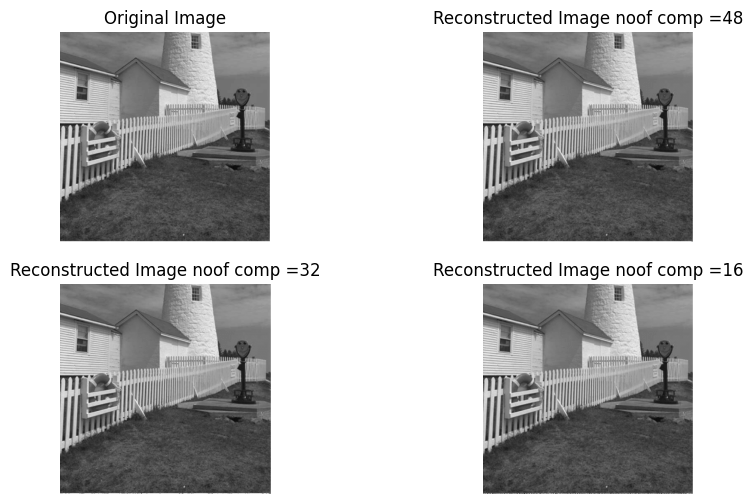

In [4]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

for i, n_comp in enumerate([48, 32, 16]):
    plt.subplot(2, 2, i+2)
    plt.imshow(comp_img[i], cmap='gray')
    plt.title(f'Reconstructed Image noof comp ={n_comp}')
    plt.axis('off')

plt.show()

<p>we can see pca is effective in decorelating images as we can see even with 16 componets we still retain the most detailes in the image</p>

### Question 2

In [5]:
class jpeg:
    def __init__(self):
        self.Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                           [12, 12, 14, 19, 26, 58, 60, 55],
                           [14, 13, 16, 24, 40, 57, 69, 56],
                           [14, 17, 22, 29, 51, 87, 80, 62],
                           [18, 22, 37, 56, 68, 109, 103, 77],
                           [24, 35, 55, 64, 81, 104, 113, 92],
                           [49, 64, 78, 87, 103, 121, 120, 101],
                           [72, 92, 95, 98, 112, 100, 103, 99]])
        self.width = None
        self.length = None

    def C(self, a):
        if a == 0:
            return 1 / np.sqrt(2)
        return 1

    # Encoder
    def divide_blocks(self, image):
        size = 8
        self.length, self.width = image.shape
        if self.length % size != 0 or self.width % size != 0:
            print("Invalid shape")
            return None
        result = np.zeros((self.length * self.width // (size * size), size, size))
        idx = 0
        for i in range(0, self.length, size):
            for j in range(0, self.width, size):
                result[idx] = image[i:i+size, j:j+size]
                idx += 1
        return result

    def dct(self, block):
        m, n = block.shape
        block_ = np.zeros_like(block, dtype=np.float64)

        def generate_matrix(u, v):
            temp = np.zeros_like(block, dtype=np.float64)
            for i in range(m):
                for j in range(n):
                    temp[i][j] = 4 * np.cos((2 * i + 1) * u * np.pi / (2 * m)) * np.cos((2 * j + 1) * v * np.pi / (2 * n)) / (m * n)
            return self.C(u) * self.C(v) * temp

        for u in range(m):
            for v in range(n):
                t1 = generate_matrix(u, v)
                block_[u][v] = np.sum(block * t1)
        return block_

    def mul_quantization(self, block):
        result = np.floor(block/self.Q + 0.5)
        return result

    # Decoder
    def mul_inverse_quantization(self, block):
        result = block*self.Q
        return result

    def idct(self, block):
        m, n = block.shape
        block_ = np.zeros_like(block, dtype=np.float64)

        def generate_matrix(i, j):
            temp = np.zeros_like(block, dtype=np.float64)
            for u in range(m):
                for v in range(n):
                    temp[u][v] = self.C(u) * self.C(v) * np.cos((2*i + 1)*u* np.pi/(2*m))*np.cos((2*j + 1)*v*np.pi/(2 * n))
            return temp

        for i in range(m):
            for j in range(n):
                t1 = generate_matrix(i, j)
                block_[i][j] = np.sum(block * t1)
        return block_

    def merge_blocks(self, blocks):
        m, n = self.length, self.width
        result = np.zeros((m, n))
        idx = 0
        for i in range(0, m, 8):
            for j in range(0, n, 8):
                result[i:i+8, j:j+8] = blocks[idx]
                idx += 1
        return result


(696, 696)


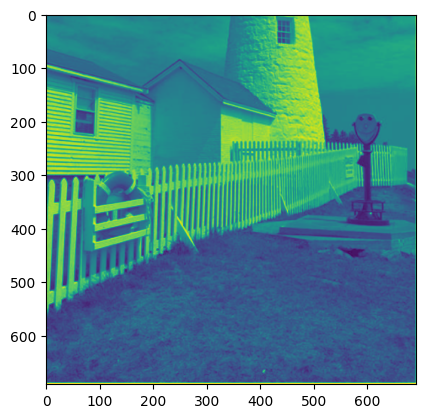

In [6]:
img = Image.open("lighthouse.png").convert("L")
img_array = np.array(img)
plt.imshow(img_array)
height, width = img_array.shape

pad_height = (8 - height % 8) % 8
pad_width = (8 - width % 8) % 8
img_array = np.pad(img_array, ((0, pad_height), (0, pad_width)), mode='edge')
print(img_array.shape)

In [7]:
jpg = jpeg()

# encoding 
blocks = jpg.divide_blocks(img_array)
dct_blocks = [jpg.dct(block) for block in blocks]
quantized_blocks = [jpg.mul_quantization(block) for block in dct_blocks]

In [8]:
print(quantized_blocks[0])

[[14.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


<p>we are left with sparse coefficients at this point</p>

In [9]:
# decoding
inverse_quantized_blocks = [jpg.mul_inverse_quantization(block) for block in quantized_blocks]
idct_blocks = [jpg.idct(block) for block in inverse_quantized_blocks]
merged_image = jpg.merge_blocks(idct_blocks)

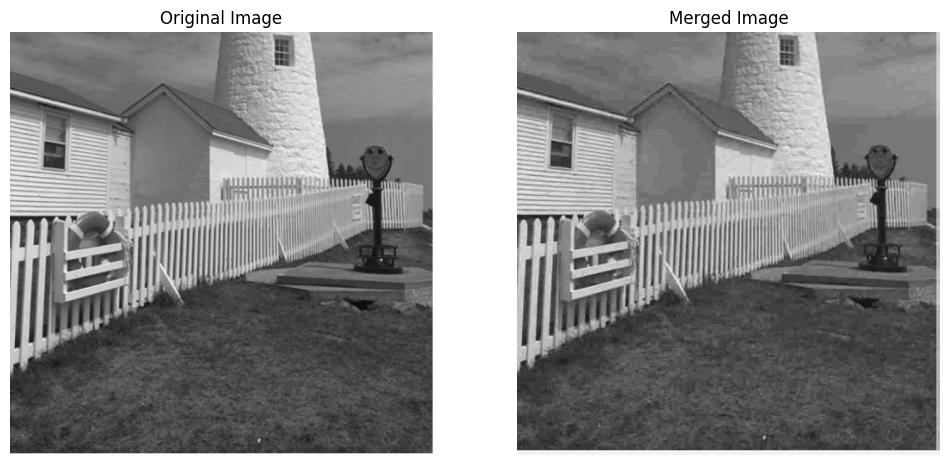

In [10]:
img = Image.open("lighthouse.png").convert("L")
img_array = np.array(img)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_array, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(merged_image, cmap='gray')
axes[1].set_title('Merged Image')
for ax in axes:
    ax.axis('off')
plt.show()

<p>We can see we almost reconstructed the image with some of the detailes lost but still effective for most part</p>

### Question 3

In [11]:
class motion_detection:
    def __init__(self):
        self.nn1 = np.array([[-4,-4],[-4,0],[-4,4],[0,-4],[0,0],[0,4],[4,-4],[4,0],[4,4]])
        self.nn2 = np.array([[-2,-2],[-2,0],[-2,2],[0,-2],[0,0],[0,2],[2,-2],[2,0],[2,2]])
        self.nn3 = np.array([[-1,-1],[-1,0],[-1,1],[0,-1],[0,0],[0,1],[1,-1],[1,0],[1,1]])

    def MAD(self, b1, b2):
        assert b1.shape == b2.shape, "Blocks must have same shape"
        mad_value = np.mean(np.abs(b1 - b2))
        return mad_value

    def three_step_search(self, frame, next_frame, size=16):
        m, n = frame.shape
        assert m % size == 0 and n % size == 0, "Invalid size"

        INF = float('inf')

        def valid(new1, new2):
            return 0 <= new1 < m - size and 0 <= new2 < n - size
        
        def step(nearest_pts, loc1, loc2):
            scores = []
            for pt in nearest_pts:
                new1, new2 = pt[0] + loc1, pt[1] + loc2
                if valid(new1, new2):
                    val = self.MAD(frame[loc1:loc1+size, loc2:loc2+size], next_frame[new1:new1+size, new2:new2+size])
                    scores.append(val)
                else:
                    scores.append(INF)
            i_min = np.argmin(scores)
            return (loc1 + nearest_pts[i_min][0], loc2 + nearest_pts[i_min][1])

        dxns = []
        for i in range(0, m, size):
            ls = []
            for j in range(0, n, size):
                point1 = step(self.nn1, i, j)
                point2 = step(self.nn2, point1[0], point1[1])
                point3 = step(self.nn3, point2[0], point2[1])
                dxn = (point3[0] - i,point3[1] - j)
                ls.append(dxn)
            dxns.append(ls)
        return dxns

    def arrow_plot(self, frame, dxns):
        plt.imshow(frame, cmap='gray')
        for i in range(len(dxns)):
            for j in range(len(dxns[0])):
                dx, dy = dxns[i][j]
                plt.arrow(j*16 + 8, i*16 + 8,dy,dx,width=.8, edgecolor='yellow',linewidth=1)
        plt.axis('off')
        plt.show()

    def motion_compensated_frame_prediction(self, frame, dxns, size=16):
        m, n = frame.shape
        predicted_frame = np.zeros((m, n))
        for i in range(0, m, size):
            for j in range(0, n, size):
                dx, dy = dxns[i // size][j // size]  
                predicted_frame[i:i+size, j:j+size] = frame[i+dx:i+dx+size, j+dy:j+dy+size]
        return predicted_frame

    def prediction_error(self, pred_frame, actual_frame):
        return self.MAD(pred_frame,actual_frame)


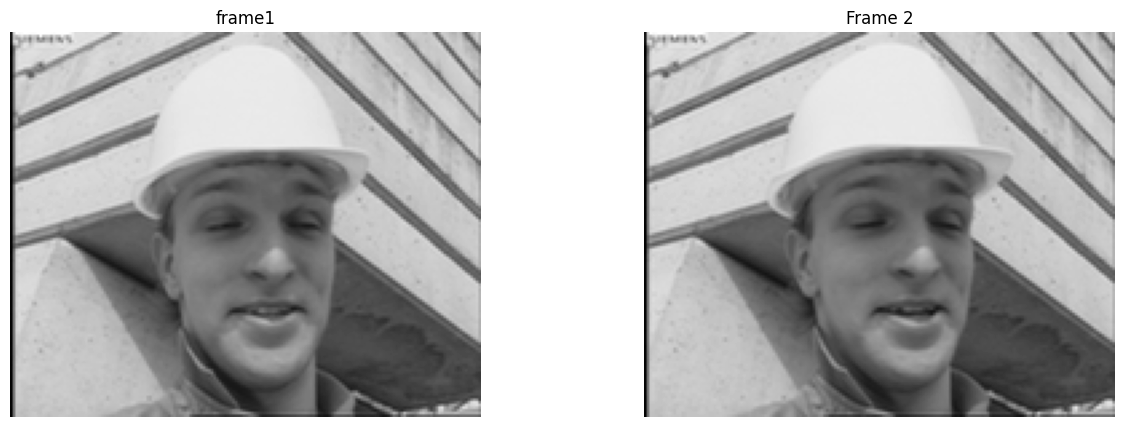

In [12]:
frame1 = Image.open("first_frame.png").convert("L")
frame1_array = np.array(frame1)

frame2 = Image.open("second_frame.png").convert("L")
frame2_array = np.array(frame2)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(frame1_array, cmap='gray')
axes[0].set_title('frame1')
axes[1].imshow(frame2_array, cmap='gray')
axes[1].set_title('Frame 2')
for ax in axes:
    ax.axis('off')
plt.show()

In [13]:
motion_detector = motion_detection()
dxns = motion_detector.three_step_search(frame1_array, frame2_array)
print(dxns)

[[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, -5), (0, 5), (1, 7), (1, 7), (0, 4), (0, -4)], [(0, 0), (0, 0), (0, 0), (0, 0), (7, -7), (5, -7), (-3, 7), (3, 7), (-7, 7), (-7, 1), (-4, -4)], [(0, 0), (0, 0), (0, 0), (0, 0), (7, -3), (0, 2), (0, 7), (-1, 7), (0, 0), (-6, 1), (1, -3)], [(0, 0), (0, 0), (7, 7), (4, 3), (1, 7), (-3, 7), (-4, 7), (-3, -2), (-3, -3), (4, 0), (-4, -4)], [(0, 0), (6, 6), (0, 0), (3, 1), (-1, 7), (-3, 3), (-1, 7), (0, 0), (6, -6), (0, 0), (0, -4)], [(-6, 7), (0, 7), (4, 7), (0, -7), (7, -1), (-7, 6), (3, 1), (4, 6), (0, 0), (4, -4), (4, -4)], [(-3, 7), (-7, 7), (-3, 7), (-5, 2), (5, -4), (7, 7), (1, 7), (0, 7), (0, 4), (4, -4), (6, -6)], [(-4, 4), (-6, 7), (-7, 7), (-7, 1), (7, 4), (3, 7), (3, 7), (7, 4), (0, 0), (-4, 0), (4, -4)], [(-4, 4), (-1, 7), (-7, 7), (-7, 7), (-2, 6), (-3, -6), (-1, -3), (-2, -5), (-4, -4), (-4, -4), (-4, -4)]]


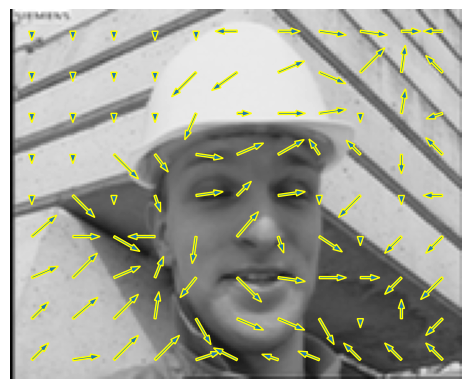

In [14]:
motion_detector.arrow_plot(frame1_array, dxns)

In [15]:
predicted_frame2 = motion_detector.motion_compensated_frame_prediction(frame1_array, dxns)

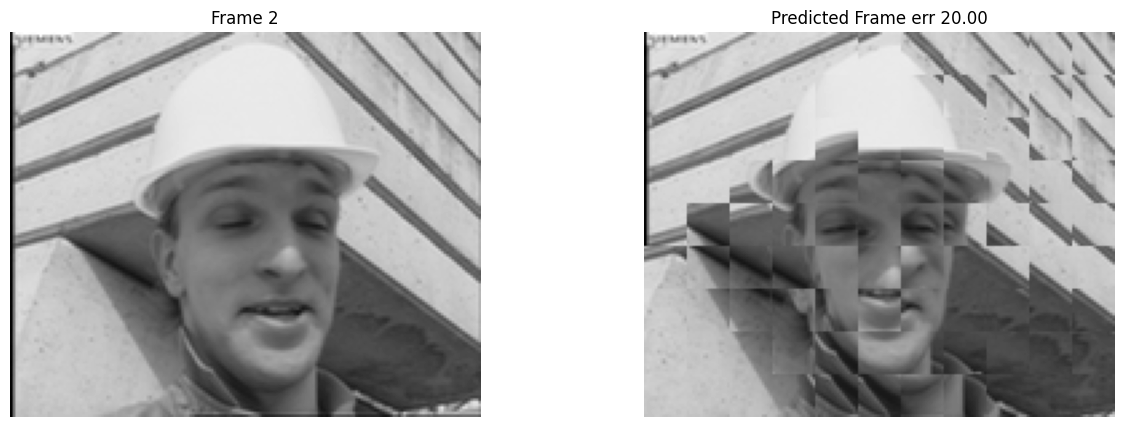

In [17]:
err = motion_detector.prediction_error(predicted_frame2, frame2_array)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(frame2_array, cmap='gray')
axes[0].set_title('Frame 2')
axes[1].imshow(predicted_frame2, cmap='gray')
axes[1].set_title('Predicted Frame err {:.2f}'.format(err))
for ax in axes:
    ax.axis('off')
plt.show()